## 5.5 选择合适的损失函数

1.torch.nn.MSELoss代码示例

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(10)

loss = nn.MSELoss(reduction='mean')
input = torch.randn(1, 2, requires_grad=True)
print(input)
target = torch.randn(1, 2)
print(target)
output = loss(input, target)
print(output)
output.backward()


tensor([[-0.6014, -1.0122]], requires_grad=True)
tensor([[-0.3023, -1.2277]])
tensor(0.0680, grad_fn=<MseLossBackward>)


2.torch.nn.CrossEntropyLoss代码示例

In [2]:
import torch
import torch.nn as nn

torch.manual_seed(10)

loss = nn.CrossEntropyLoss()
#假设类别数为5
input = torch.randn(3, 5, requires_grad=True)
#每个样本对应的类别索引,其值范围为[0,4]
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

## 5.6 使用合适优化器

### 5.6.2 批量随机梯度下降法

In [1]:
import numpy as np
import torch
import time
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist 
#import torchvision
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [2]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

In [4]:
#定义预处理函数
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('../data', train=True, transform=transform, download=False)
test_dataset = mnist.MNIST('../data', train=False, transform=transform)
#得到一个生成器
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

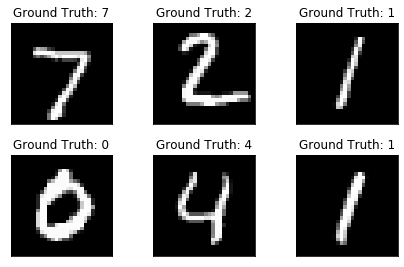

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### 加载数据

In [6]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [7]:
loss_cnt = nn.CrossEntropyLoss()

In [8]:
def sgd_update(parameters, lr):
    for param in parameters:
        param.data -= lr * param.grad
        param.grad.data.zero_()

### 定义模型

In [9]:
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

### 训练模型

In [10]:
# 开始训练
losses1 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for img, label in train_loader:
        #展平img
        img=img.view(img.size(0),-1)
        # 前向传播
        out = net(img)
        loss = loss_cnt(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(), 1e-2) # 使用 0.01 的学习率
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses1.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_loader)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.345866
epoch: 1, Train Loss: 0.212836
epoch: 2, Train Loss: 0.170220
epoch: 3, Train Loss: 0.155545
epoch: 4, Train Loss: 0.137840
使用时间: 261.23325 s


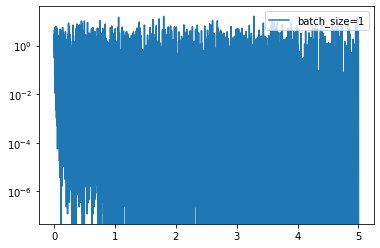

In [11]:
x_axis = np.linspace(0, 5, len(losses1), endpoint=True)
plt.semilogy(x_axis, losses1, label='batch_size=1')
plt.legend(loc='best')

可以看到，loss 在剧烈震荡，因为每次都是只对一个样本点做计算，每一层的梯度都具有很高的随机性，而且需要耗费了大量的时间

### 批量随机梯度下降法

In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [10]:
net1 = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [12]:
# 开始训练
losses1 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for img, label in train_loader:
        #展平img
        img=img.view(img.size(0),-1)
        # 前向传播
        out = net1(img)
        loss = loss_cnt(out, label)
        # 反向传播
        net1.zero_grad()
        loss.backward()
        sgd_update(net1.parameters(), 1e-2) # 使用 0.01 的学习率
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses1.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_loader)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.721458
epoch: 1, Train Loss: 0.364912
epoch: 2, Train Loss: 0.319628
epoch: 3, Train Loss: 0.292893
epoch: 4, Train Loss: 0.270584
使用时间: 46.09111 s


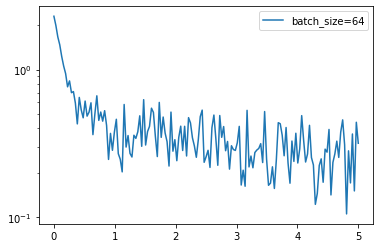

In [13]:
x_axis = np.linspace(0, 5, len(losses1), endpoint=True)
plt.semilogy(x_axis, losses1, label='batch_size=64')
plt.legend(loc='best')